In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt

img_name = 'img/lena_std.tif'
img = cv.imread(img_name, cv.IMREAD_GRAYSCALE)
hist = cv.calcHist([img], [0], None, [256], [0,256])
cdf = hist.ravel().cumsum()
cdf_normal = cdf / cdf[-1]
hist_normal = hist / cdf[-1]

Text(0.5, 1.0, 'cdf_normal')

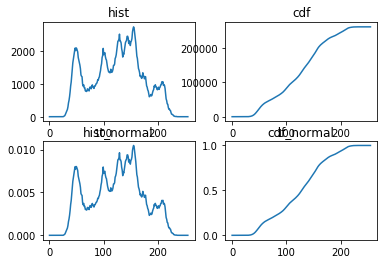

In [2]:
fig, ax_list = plt.subplots(2, 2)
ax_list[0][0].plot(hist)
ax_list[0][0].set_title('hist')
ax_list[0][1].plot(cdf)
ax_list[0][1].set_title('cdf')
ax_list[1][0].plot(hist_normal)
ax_list[1][0].set_title('hist_normal')
ax_list[1][1].plot(cdf_normal)
ax_list[1][1].set_title('cdf_normal')

In [3]:
def max_entropy(hist):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    参考：https://github.com/zenr/ippy/blob/master/segmentation/max_entropy.py
    Params:
        hist [np.array]: 图像灰度直方图。（未归一化的）
    Return:
        threshold [int]: threshold calculated by 一维最大熵算法
    """

    # calculate normalized CDF (cumulative density function)
    cdf = hist.cumsum()
    cdf_normal = cdf / cdf[-1]
    hist_normal = hist / cdf[-1]

    valid_range = np.nonzero(hist_normal)[0]
    s_range = hist_normal[hist_normal != 0]
    H_s_cum = -np.cumsum(s_range * np.log(s_range))

    H_n = H_s_cum[-1]

    max_ent, threshold = 0, 0
    ents = []
    for i in range(len(H_s_cum) - 1): # 忽略最后一个非零点，防止P_s为1导致(1 - P_s)为0
        s = valid_range[i]
        P_s = cdf_normal[s]
        H_s = H_s_cum[i]
        total_ent = np.log(P_s * (1 - P_s)) + H_s/P_s + (H_n - H_s)/(1 - P_s)
        
        ents.append(total_ent)
        # find max
        if total_ent > max_ent:
            max_ent, threshold = total_ent, s

    return threshold, max_ent, valid_range, ents

In [4]:
threshold, max_ent, valid_range, ents = max_entropy(hist.ravel())

122


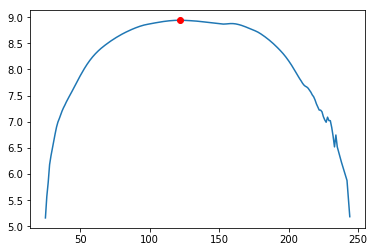

In [5]:
plt.plot(valid_range[:-1], ents)
plt.plot(threshold, max_ent, 'ro')
print(threshold)

threshod calculated by 最大熵分割算法: 122


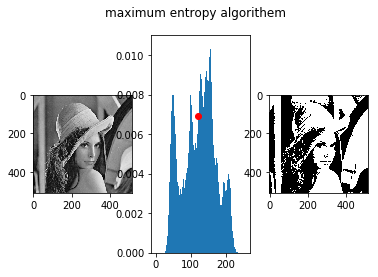

In [6]:
_, thr_img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)
fig, ax_list = plt.subplots(1, 3)
fig.suptitle('maximum entropy algorithem')
ax_list[0].imshow(img, 'gray')

ax_list[1].hist(img.ravel(), 256, [0,256], density=True)
ax_list[1].plot(threshold, hist_normal[threshold], 'ro')

ax_list[2].imshow(thr_img, 'gray')

print(f'threshod calculated by 最大熵分割算法: {threshold}')
plt.show()

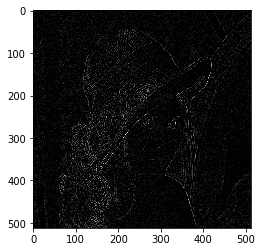

In [7]:
lap_img = abs(cv.Laplacian(img, -1))
lap_hist = cv.calcHist([lap_img], [0], None, [256], [0,256])

plt.imshow(lap_img, 'gray')

110


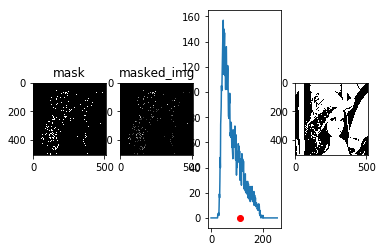

In [8]:
T = np.max(lap_img) * 0.2
_, mask = cv.threshold(lap_img, T, 255, cv.THRESH_BINARY)
masked_img = cv.bitwise_and(img, img, mask=mask)
hist_mask = cv.calcHist([img], [0], mask, [256], [0,256])

th2, max_ent, valid_range, ents = max_entropy(hist_mask.ravel())
_, thr_img = cv.threshold(img, th2, 255, cv.THRESH_BINARY)

fig, ax_list = plt.subplots(1, 4)
ax_list[0].imshow(mask, 'gray')
ax_list[0].set_title('mask')

ax_list[1].imshow(masked_img, 'gray')
ax_list[1].set_title('masked_img')


ax_list[2].plot(hist_mask)
ax_list[2].plot(th2, 0, 'ro')

ax_list[3].imshow(thr_img, 'gray')

print(th2)